<a href="https://colab.research.google.com/github/HarshiniAiyyer/WinnieDaPooh/blob/main/3_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Exploratory Data Analysis

### Agenda

- Source IPs generated per session frequency

- Inter-arrival times per source (to hint at beaconing/scans).

- State protocol distribution, port usage distribution.

- Unique dest IPs per source (helps flag scanning).

- Identify connections that have SYN (half-open connections - check previous notebook for this).

- Looking for sketchy IPs, which is a consolidation of the above things + some extra analysis.

### Variables we need

- ```InterArrivalTime```
- ```UniqueDstPorts```
- ```Duration```
- ```PacketRate```
- ```ByteRate```
- ```SessionCount```
- ```HalfOpenRatio```

Since these aren't present in this notebook by default I have bring them from the other notebook. I will hide the code snippets that bring them here.

#### Bringing the variables from the other notebook here

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/HarshiniAiyyer/WinnieDaPooh/refs/heads/main/hdata.csv')

In [ ]:
df['StartTime'] = pd.to_datetime(df['StartTime'])
df['Day'] = df['StartTime'].dt.day_name()
df['Weekend?'] = df['Day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

In [ ]:
df['HourBin'] = df['StartTime'].dt.floor('h')
sesscount = df.groupby(['SrcAddr', 'HourBin']).size().reset_index(name = 'SessionCount')
df = df.merge(sesscount, on=['SrcAddr', 'HourBin'], how='left')

In [ ]:
df = df.sort_values(by=['SrcAddr', 'StartTime']).reset_index(drop=True)

# Time difference per start time per source address
df['InterArrivalTime'] = df.groupby('SrcAddr')['StartTime'].diff().dt.total_seconds()

# fill null values with 0
df['InterArrivalTime'] = df['InterArrivalTime'].fillna(0)

In [ ]:
df['BytesPerPacket'] = df['TotBytes'] / df['TotPkts']
df['SrcByteRatio'] = df['SrcBytes'] / df['TotBytes']
unique_dst_ports = df.groupby('SrcAddr')['Dport'].nunique().reset_index(name='UniqueDstPorts')
df = df.merge(unique_dst_ports, on='SrcAddr', how='left')

In [ ]:
# 1. PacketRate & ByteRate
df['PacketRate'] = df['TotPkts'] / df['Dur'].replace(0, np.nan)
df['ByteRate']   = df['TotBytes'] / df['Dur'].replace(0, np.nan)

In [ ]:
#finding half open states

half_open_states = ['S_RA','SR_RA','SA_R','SR_','SRA_RA']
df['IsHalfOpen'] = df['State'].isin(half_open_states).astype(int)
# Group by source and hour to count half-opens and totals
half_count = df.groupby(['SrcAddr','HourBin'])['IsHalfOpen'].sum().reset_index(name='HalfOpenCount')
total = df.groupby(['SrcAddr','HourBin']).size().reset_index(name='TotalFlows')

In [ ]:
# Merge and calculate ratio
ratio = half_count.merge(total, on=['SrcAddr','HourBin'])
ratio['HalfOpenCount'] = pd.to_numeric(ratio['HalfOpenCount'], errors='coerce')
ratio['TotalFlows'] = pd.to_numeric(ratio['TotalFlows'], errors='coerce')
ratio['HalfOpenRatio'] = ratio['HalfOpenCount'] / ratio['TotalFlows']

In [ ]:
# Merge back to main df
df = df.merge(ratio[['SrcAddr','HourBin','HalfOpenRatio']], on=['SrcAddr','HourBin'], how='left')

In [ ]:
df[['PacketRate', 'ByteRate']].isna().sum()
df.dropna(subset=['PacketRate', 'ByteRate'], inplace=True)

In [ ]:
# Finally, save updated feature set
#df.to_csv('feature_engineered_dataset.csv', index=False)

# EDA Begins here (CLICK HERE TO START !)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/HarshiniAiyyer/WinnieDaPooh/refs/heads/main/data/eda_data.csv')
df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,...,HourBin,SessionCount,InterArrivalTime,BytesPerPacket,SrcByteRatio,UniqueDstPorts,PacketRate,ByteRate,IsHalfOpen,HalfOpenRatio
0,2021-05-18 12:13:07.477559,0.701775,tcp,1.0.202.88,65088,->,159.65.26.180,445,S_RA,0,...,2021-05-18 12:00:00,1,0.00000,60.000000,0.550000,1,5.699833,3.419900e+02,1,1.0
1,2021-05-18 08:59:49.060017,0.693597,tcp,1.0.218.64,63714,->,159.65.26.180,445,S_RA,0,...,2021-05-18 08:00:00,1,0.00000,60.000000,0.550000,1,5.767038,3.460223e+02,1,1.0
2,2021-05-18 04:20:30.247947,1.401538,tcp,1.10.184.106,57608,->,159.65.26.180,445,S_RA,0,...,2021-05-18 04:00:00,1,0.00000,59.333333,0.544944,1,4.281011,2.540067e+02,1,1.0
3,2021-05-18 23:28:51.417054,0.000031,tcp,1.116.14.134,32964,->,167.99.141.164,6379,S_RA,96,...,2021-05-18 23:00:00,2,0.00000,64.000000,0.578125,1,64516.129032,4.129032e+06,1,1.0
4,2021-05-18 23:49:28.548574,0.000040,tcp,1.116.14.134,35922,->,167.71.64.32,6379,S_RA,96,...,2021-05-18 23:00:00,2,1237.13152,64.000000,0.578125,1,50000.000000,3.200000e+06,1,1.0


In [3]:
# 'Startime to datetime datatype
df['StartTime'] = pd.to_datetime(df['StartTime'])

df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,...,HourBin,SessionCount,InterArrivalTime,BytesPerPacket,SrcByteRatio,UniqueDstPorts,PacketRate,ByteRate,IsHalfOpen,HalfOpenRatio
0,2021-05-18 12:13:07.477559,0.701775,tcp,1.0.202.88,65088,->,159.65.26.180,445,S_RA,0,...,2021-05-18 12:00:00,1,0.00000,60.000000,0.550000,1,5.699833,3.419900e+02,1,1.0
1,2021-05-18 08:59:49.060017,0.693597,tcp,1.0.218.64,63714,->,159.65.26.180,445,S_RA,0,...,2021-05-18 08:00:00,1,0.00000,60.000000,0.550000,1,5.767038,3.460223e+02,1,1.0
2,2021-05-18 04:20:30.247947,1.401538,tcp,1.10.184.106,57608,->,159.65.26.180,445,S_RA,0,...,2021-05-18 04:00:00,1,0.00000,59.333333,0.544944,1,4.281011,2.540067e+02,1,1.0
3,2021-05-18 23:28:51.417054,0.000031,tcp,1.116.14.134,32964,->,167.99.141.164,6379,S_RA,96,...,2021-05-18 23:00:00,2,0.00000,64.000000,0.578125,1,64516.129032,4.129032e+06,1,1.0
4,2021-05-18 23:49:28.548574,0.000040,tcp,1.116.14.134,35922,->,167.71.64.32,6379,S_RA,96,...,2021-05-18 23:00:00,2,1237.13152,64.000000,0.578125,1,50000.000000,3.200000e+06,1,1.0


## 1. Temporal Aggregation

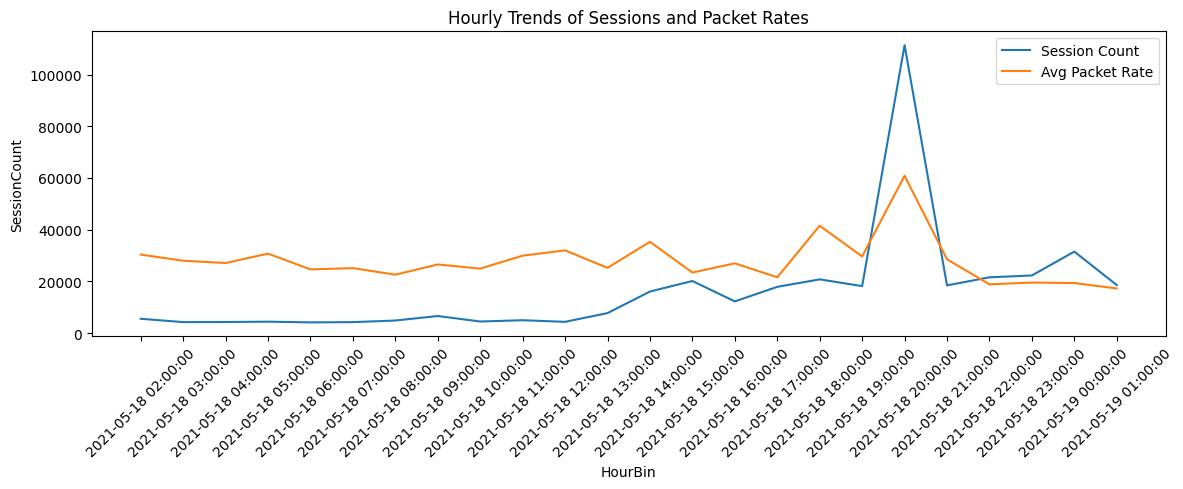

In [4]:
hourly = df.groupby(['HourBin']).agg({
    'SessionCount': 'sum',
    'ByteRate': 'mean',
    'PacketRate': 'mean',
    'HalfOpenRatio': 'mean'
}).reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly, x='HourBin', y='SessionCount', label='Session Count')
sns.lineplot(data=hourly, x='HourBin', y='PacketRate', label='Avg Packet Rate')
plt.title('Hourly Trends of Sessions and Packet Rates')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Key Findings :

- Huge sudden spike from 8PM to 9PM - with around 110k sessions for the blue line indicates some coordinated attack.

- Orange Line : Packet rate peaks align with session spikes, reaching ~60,000 compared to baseline ~25,000-30,000.

- Honeypot factors - Calm before a storm, higher traffic packet rates, varied traffic flows.

### 2. Distributions + Outlier Detection

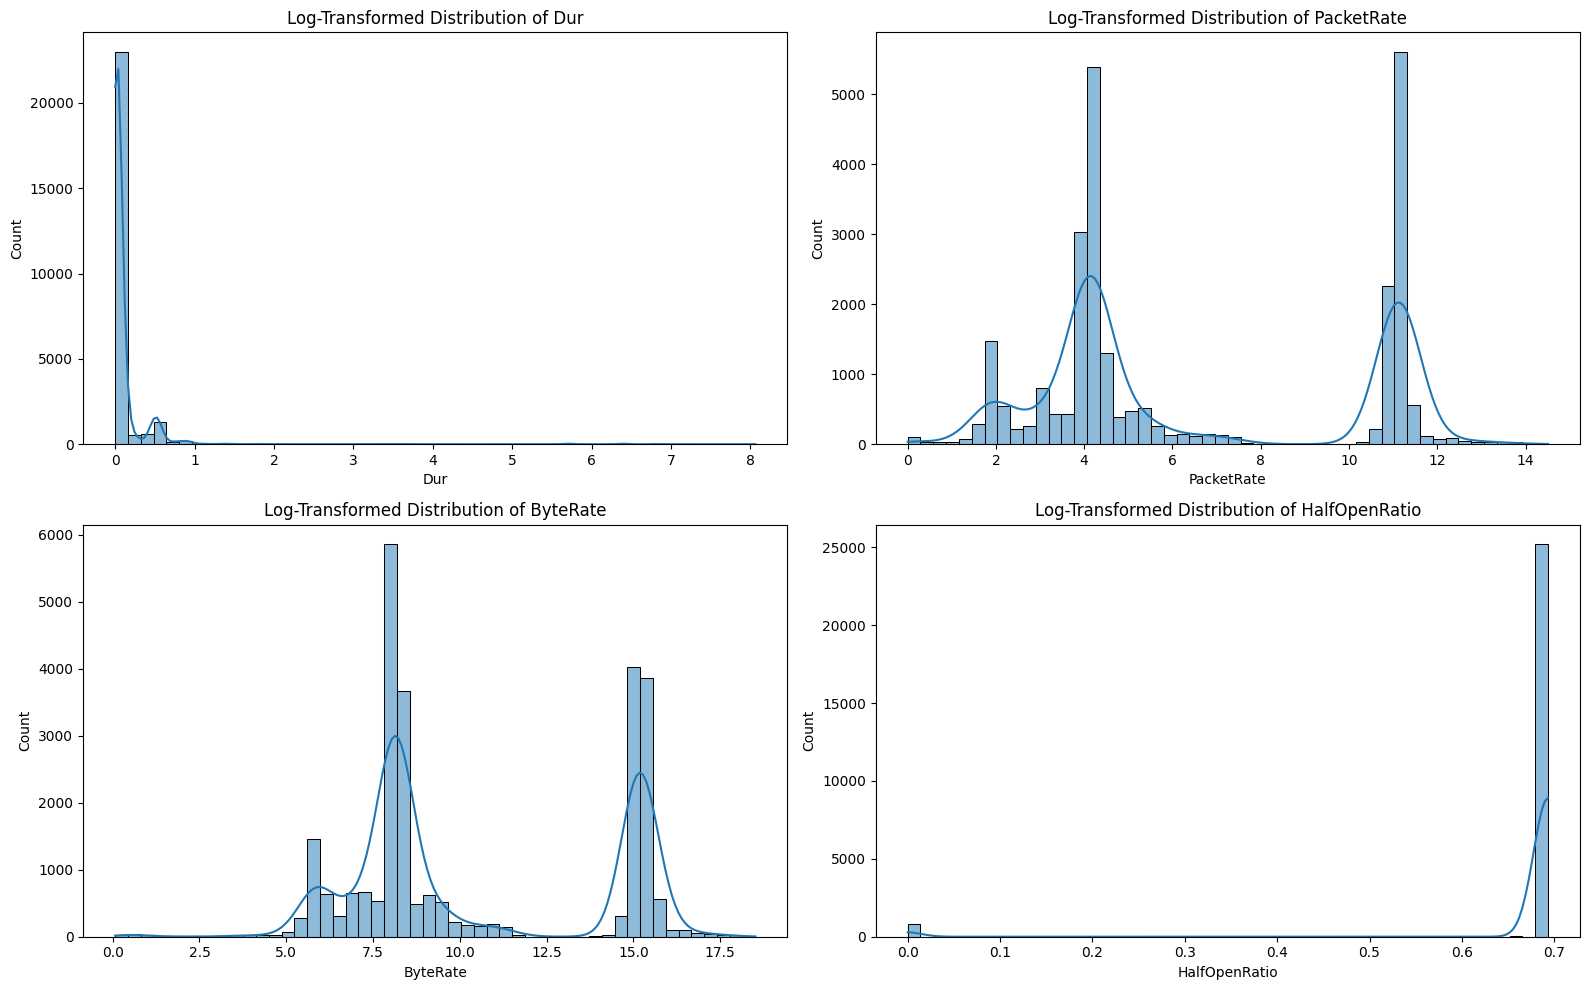

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cols = ['Dur', 'PacketRate', 'ByteRate', 'HalfOpenRatio']

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for ax, col in zip(axs.flatten(), cols):
    data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
    sns.histplot(np.log1p(data), bins=50, kde=True, ax=ax)
    ax.set_title(f'Log-Transformed Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


#### Key Findings

- Duration Distribution (Top Left):

Extreme short duration bias, data is leaning towards log(0); indicating predominantly brief, automated connections. Not natural, then botted.


- PacketRate Distribution (Top Right):

Two clear peaks at ~10^4 and ~10^12 packets/second. An obviously huge clear gap between the peaks indicates strong feature separation for malicious activity.

- ByteRate Distribution (Bottom Left):

Mirrors PacketRate with peaks at ~7.5 and ~15 on log scale
Correlation with PacketRate confirms automated tool usage rather than varied human behavior

- HalfOpenRatio Distribution (Bottom Right):

Nearly all traffic clustered at ~0.7 ratio.
High half-open ratios suggest systematic port scanning or connection attempts to non-existent services.
Most discriminative feature - legitimate networks rarely exhibit such consistently high incomplete connection ratios


### 3. Top Talkers / Suspicious IP Rankings

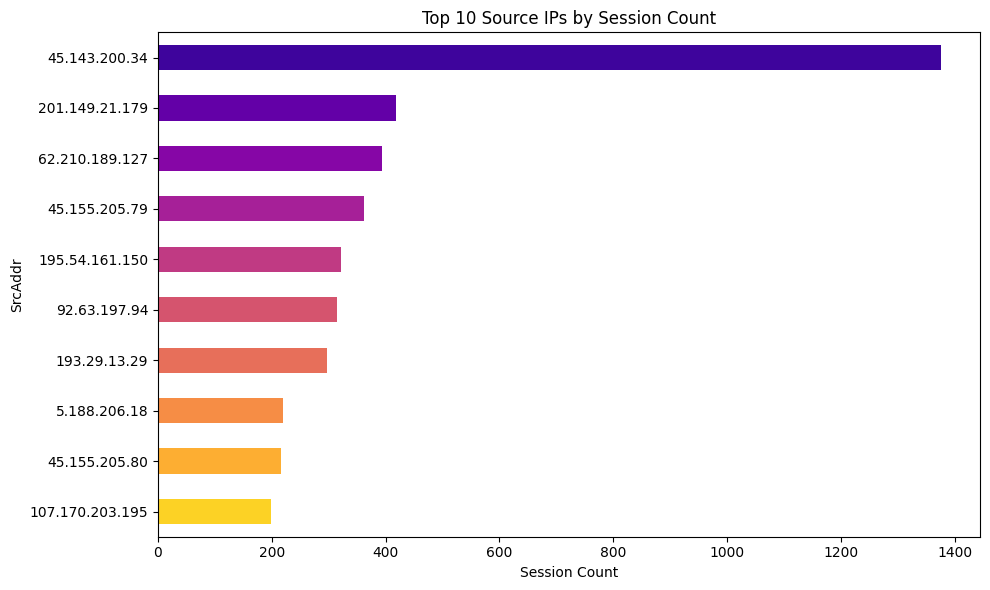

In [6]:
import seaborn as sns

# grouping source address by session frequency
top_src = df.groupby('SrcAddr').agg({
    'Dur': 'count'
}).rename(columns={'Dur': 'SessionCount'})
top_src = top_src.sort_values(by='SessionCount', ascending=False).head(10)

# list of top 10 Source IPs
top_10_ips = top_src.index.tolist()


# subplots - 1 row and 1 column
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

#viz
top_src['SessionCount'].plot(kind='barh', ax=ax, color=sns.color_palette('plasma', len(top_src)))
ax.set_title("Top 10 Source IPs by Session Count")
ax.set_xlabel("Session Count")
ax.invert_yaxis()  # inverting y axis so that the highest session count is at the top


plt.tight_layout()
plt.show()

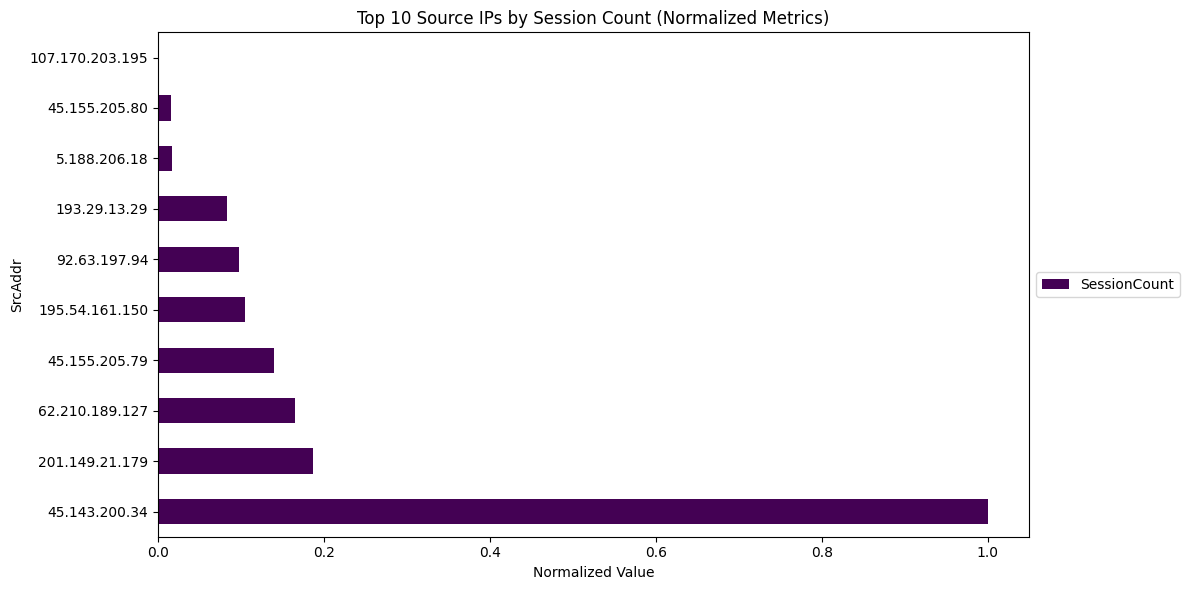

In [7]:
nor = top_src.copy()
for col in nor.columns:
    nor[col] = (nor[col] - nor[col].min()) / (nor[col].max() - nor[col].min())

nor.plot(kind='barh', figsize=(12, 6), colormap='viridis')
plt.title("Top 10 Source IPs by Session Count (Normalized Metrics)")
plt.xlabel("Normalized Value")
plt.ylabel("SrcAddr")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

#### Key Findings:

Pretty self explanatory.

### 4. Protocol State Pattern Exploration

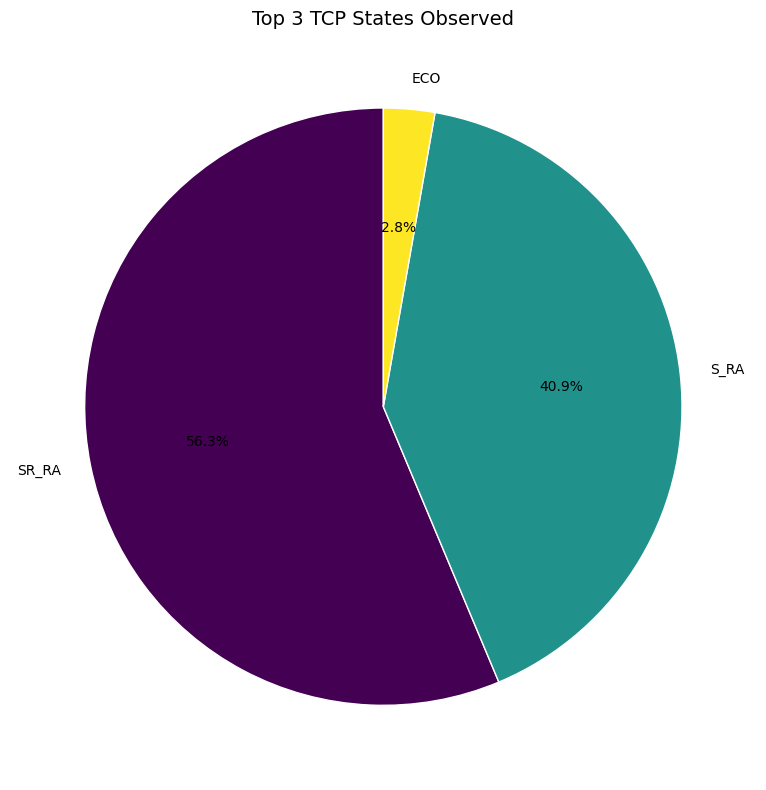

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Counts of the top 3 TCP states
state_counts = df['State'].value_counts().head(3)

plt.figure(figsize=(8, 8)) # Adjusted figure size

# Plot the pie chart
state_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='viridis', wedgeprops={'edgecolor': 'white'})

plt.title('Top 3 TCP States Observed', fontsize=14)
plt.ylabel('') # ylabel doesnt exist for a pie chart; adding this here to avoid any potential error
plt.tight_layout()
plt.show()

#### 5. Location - Wise Session and Traffic Behavior

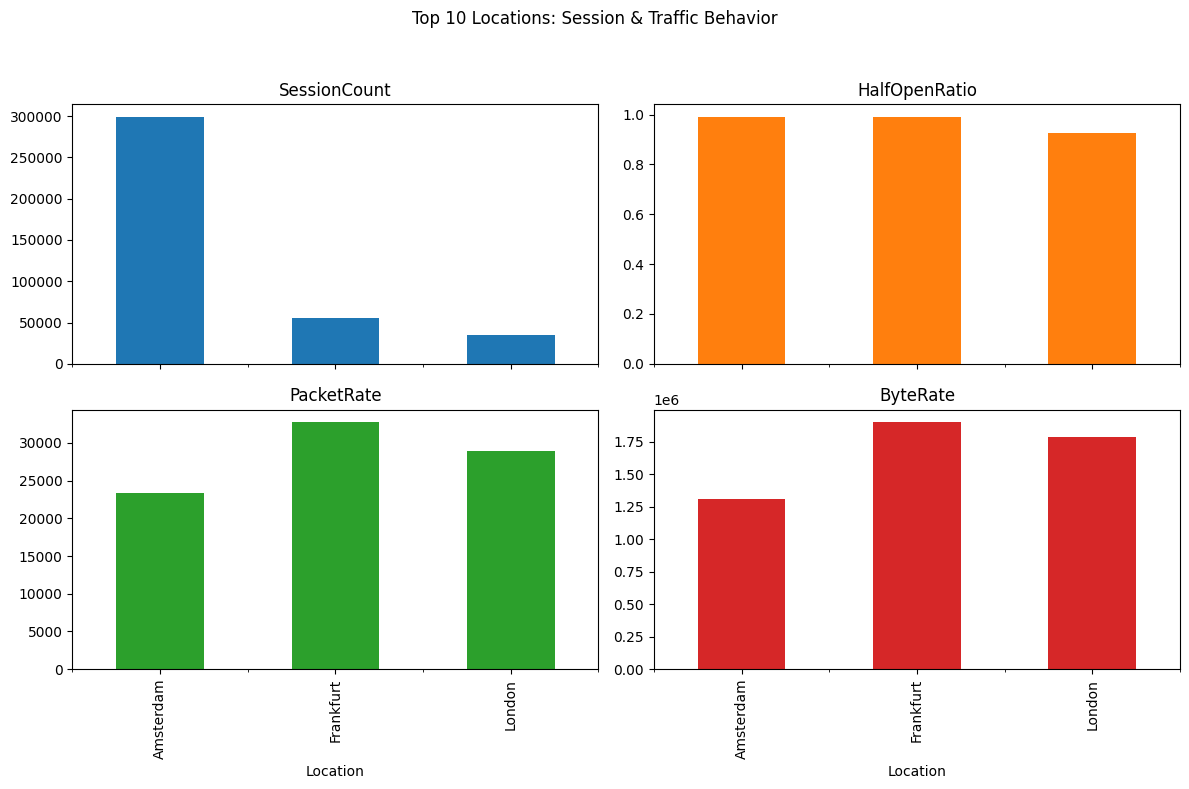

In [9]:
# Location-based behavior analysis
location_agg = df.groupby('Location').agg({
    'SessionCount': 'sum',
    'HalfOpenRatio': 'mean',
    'PacketRate': 'mean',
    'ByteRate': 'mean'
}).sort_values('SessionCount', ascending=False).head(10)

location_agg.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(12, 8), sharex=True, legend=False)
plt.suptitle('Top 10 Locations: Session & Traffic Behavior')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Key Findings

Top 10 - Geographic SessionCount (Top Left):

- Amsterdam has around 300,000 sessions : represents the primary attack source, significantly outpacing other locations compared to Frankfurt (approx 55,000) and London (approx 30,000) that show moderate attack activity.


HalfOpenRatio (Top Right):

- All three locations show ~0.95-1.0 high half-open ratios
- Extremely high half/incomplete connection rates across all geographic sources confirm probing behavior


PacketRate (Bottom Left):

- Frankfurt has the highest packet rate (~33,000) despite fewer sessions, indicating more intensive per-session scanning.
- Amsterdam shows moderate packet rates relative to session freq, while London maintains consistent activity.


ByteRate (Bottom Right):

- Frankfurt and London show ~1.8M byte rates, indicating heavy data transfer attempts.
- Despite highest session count, Amsterdam shows lower byte rates (~1.3M), suggesting lighter reconnaissance activity
- Varying byte rates indicate different attack objectives - Amsterdam for broad scanning, Frankfurt/London for intensive probing.

### 6. Interarrival Time Distribution

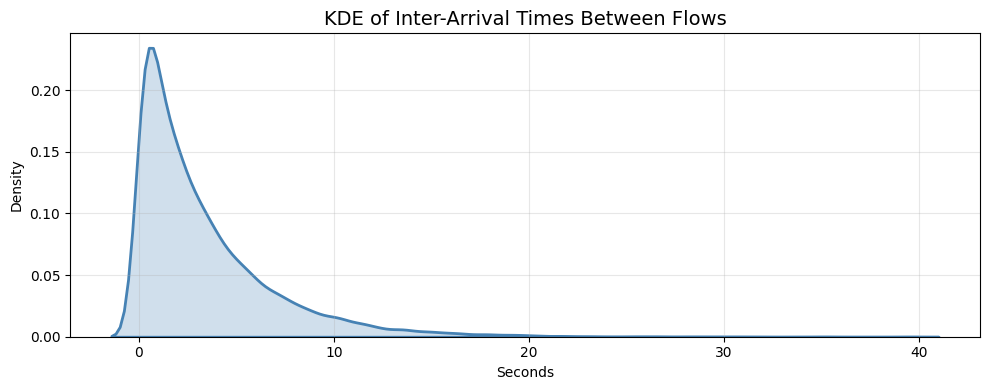

In [10]:
df_sorted = df.sort_values('StartTime')
df_sorted['InterArrival'] = df_sorted['StartTime'].diff().dt.total_seconds()
inter_arrival_times = df_sorted['InterArrival'].dropna()

plt.figure(figsize=(10, 4))
sns.kdeplot(inter_arrival_times, fill=True, color="steelblue", linewidth=2)
plt.title("KDE of Inter-Arrival Times Between Flows", fontsize=14)
plt.xlabel("Seconds")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Key Findings

- Sharp peak near 0 seconds indicates rapid-fire connection attempts

- Non-Human Timing: Absence of natural human interaction intervals confirms bot-driven traffic.

### 7. Heatmap of Feature Correlation

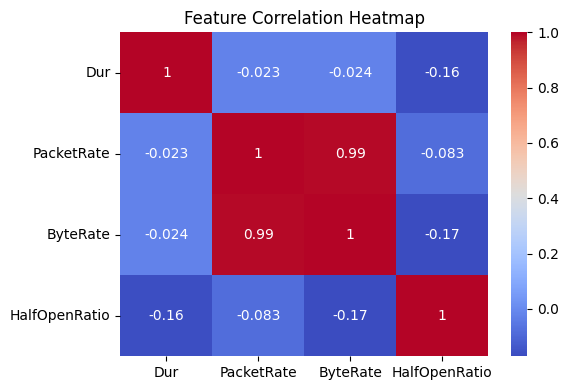

In [11]:
corr = df[cols].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

### 8. Port Usage Analysis

#### Finding average unique dest ports per hour for every unique source IP

Since it is per hourbin we use mean. Avg port per hour kinda thing.

In [12]:
src_port_usage = df.groupby('SrcAddr')['UniqueDstPorts'].mean().reset_index()

# Sort mean UniqueDstPorts in descending order
top_scanners = src_port_usage.sort_values(by='UniqueDstPorts', ascending=False).head(10) #top 10 scanners

print("Top 10 Source IPs by Average Unique Destination Ports:")
print(top_scanners)

Top 10 Source IPs by Average Unique Destination Ports:
              SrcAddr  UniqueDstPorts
4401    45.143.200.34          1375.0
4455    45.155.205.79           363.0
3283   195.54.161.150           322.0
5874     92.63.197.94           314.0
3216     193.29.13.29           297.0
4832     5.188.206.18           219.0
4456    45.155.205.80           217.0
3475   201.149.21.179           210.0
325   107.170.203.195           199.0
5150   62.210.189.127           197.0


#### Source IP VS Unique Destination Ports

<ipython-input-13-b1ecbc69ffd9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='UniqueDstPorts', y='SrcAddr', data=top_scanners, palette='viridis')


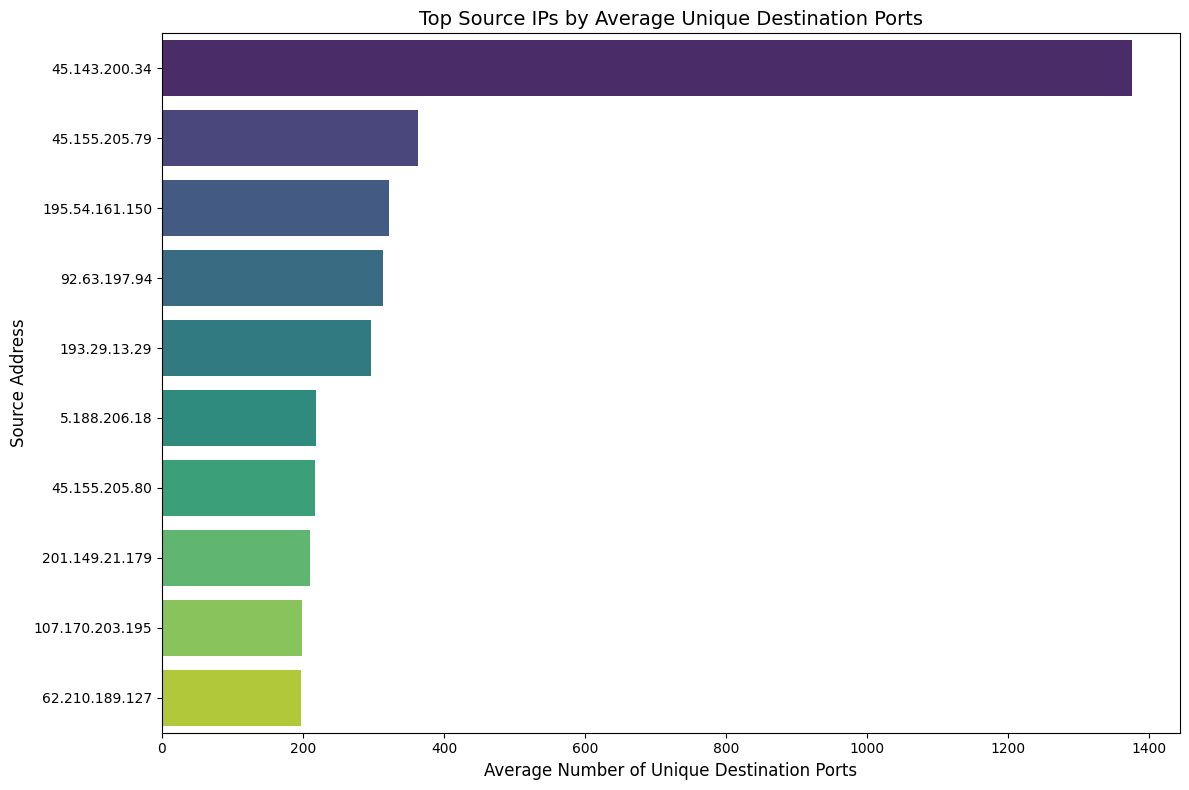

In [13]:
plt.figure(figsize=(12, 8))
sns.barplot(x='UniqueDstPorts', y='SrcAddr', data=top_scanners, palette='viridis')
plt.title('Top Source IPs by Average Unique Destination Ports', fontsize=14)
plt.xlabel('Average Number of Unique Destination Ports', fontsize=12)
plt.ylabel('Source Address', fontsize=12)
plt.tight_layout()
plt.show()

#### Flows VS Unique Destination Ports

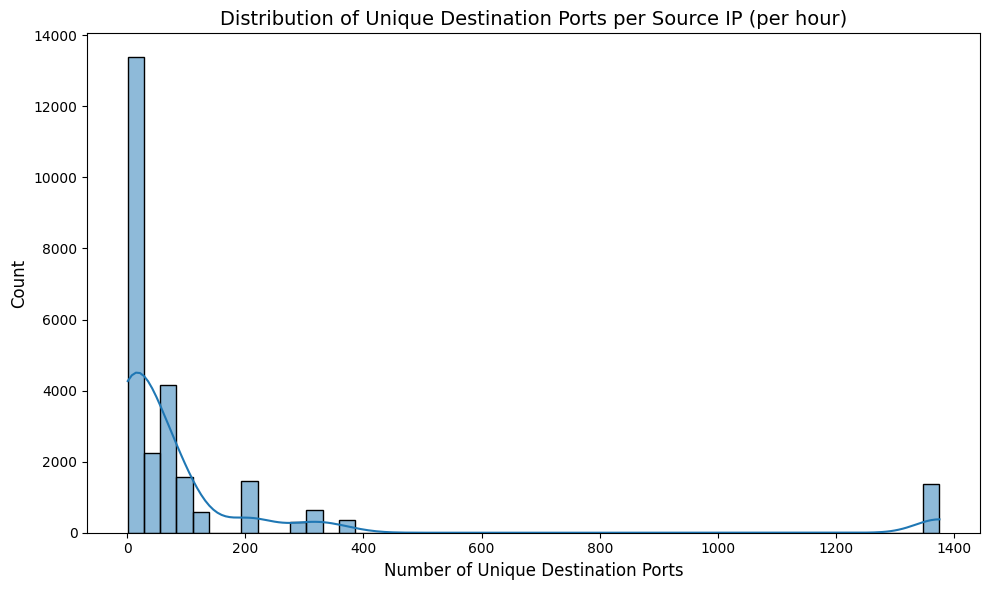

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['UniqueDstPorts'], bins=50, kde=True)
plt.title('Distribution of Unique Destination Ports per Source IP (per hour)', fontsize=14)
plt.xlabel('Number of Unique Destination Ports', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

##### Key Findings:
- Sharp peak at low port counts: ~13,500 IPs scanned ≤50 ports, likely automated, quick probes or failed scans.

- Exponential drop-off: Fewer IPs as port count increases, showing typical automated scanner behavior.

- Long-tail of intense scanners: ~1,500 IPs scanned 1,000+ ports, indicating systematic, high-effort reconnaissance.

- Attack diversity: Clear split between opportunistic probing and dedicated port sweeps, reflecting varied attacker sophistication.

### 9. Analyzing the Dur attribute

#### Quantile Analysis

In [15]:
print("\nQuantiles for Duration (Dur):")
print(df['Dur'].quantile([0.01, 0.05, 0.10, 0.50, 0.90, 0.95, 0.99]))


Quantiles for Duration (Dur):
0.01    0.000010
0.05    0.000025
0.10    0.000026
0.50    0.039521
0.90    0.310023
0.95    0.701468
0.99    1.586492
Name: Dur, dtype: float64


#### Average Duration per Source IP (Top 10)

In [16]:
avg_duration_per_src = df.groupby('SrcAddr')['Dur'].mean().sort_values()
print("\nTop 10 Source IPs with Shortest Average Duration:")
print(avg_duration_per_src.head(10))

print("\nTop 10 Source IPs with Longest Average Duration:")
print(avg_duration_per_src.tail(10))


Top 10 Source IPs with Shortest Average Duration:
SrcAddr
45.79.151.19       0.000011
139.162.3.41       0.000012
8.140.160.217      0.000015
193.29.13.29       0.000015
83.143.246.30      0.000016
194.165.16.49      0.000018
194.165.16.14      0.000019
45.129.136.15      0.000019
192.241.215.238    0.000022
186.151.241.170    0.000022
Name: Dur, dtype: float64

Top 10 Source IPs with Longest Average Duration:
SrcAddr
52.59.95.167        450.189430
13.244.107.226      499.826314
3.120.41.252        510.128317
13.245.137.200      600.297546
20.96.30.46         666.267479
146.56.203.227      746.042086
140.238.203.48      756.764538
52.80.15.59         903.546936
20.96.27.160       1188.042725
117.199.236.105    1513.052594
Name: Dur, dtype: float64


#### Duration vs. State (Median Duration per State)

- Median represents a more typical value; something that is robust to outliers and also since there is a chance for values per state to have extreme values.

- Especially the half open ones where the duration can be suspiciously too short, skewing the distribution as such.

In [17]:
median_duration_per_state = df.groupby('State')['Dur'].median().sort_values()
print("\nMedian Duration per State:")
print(median_duration_per_state)


Median Duration per State:
State
SAE_R        0.000029
ECO          0.000030
RA_R         0.000030
SA_R         0.000030
S_RA         0.000031
SAEC_R       0.000032
R_A          0.000033
SRA_RA       0.000326
SR_SA        0.008459
SR_RA        0.048639
SPA_SRPA     0.122209
SEC_RA       0.607121
FSPA_FSPA    1.573425
FSA_FSPA     2.161488
SRPA_RA      2.999331
FSRPA_RA     5.033635
Name: Dur, dtype: float64


### 10. Looking for Sketchy Ports

- Step 1: Identify Potential Scanners based on Unique Destinations and Duration

- Step 2: Analyze Port Usage and States for Potential Scanners

- Step 3: Investigate Other Flow Characteristics

---

#### Step 1: Identify Potential Scanners based on Unique Destinations and Duration

##### Calculate average UniqueDstPorts and average Dur for each SrcAddr

In [18]:
scanner_candidates = df.groupby('SrcAddr').agg({
    'UniqueDstPorts': 'mean',
    'Dur': 'mean'
}).reset_index()

##### Criteria : High Unique Dst ports each of low duration

- If a given IP generates a huge number of ports and each of them have a short duration, it can be flagged as suspicious

- Here, lets say the higher duration is 95% and lower is 5%.

- That is, we put top 95% of the unique dst port counts as high, and 5% as low.

In [19]:
high_unique_ports_threshold = scanner_candidates['UniqueDstPorts'].quantile(0.95)
low_duration_threshold = scanner_candidates['Dur'].quantile(0.05)

potential_scanners = scanner_candidates[
    (scanner_candidates['UniqueDstPorts'] >= high_unique_ports_threshold) &
    (scanner_candidates['Dur'] <= low_duration_threshold)
].sort_values(by=['UniqueDstPorts', 'Dur'], ascending=[False, True])

print("Potential Scanner IPs (High Unique Ports and Low Duration):")
print(potential_scanners)

Potential Scanner IPs (High Unique Ports and Low Duration):
             SrcAddr  UniqueDstPorts       Dur
3216    193.29.13.29           297.0  0.000015
3239   194.165.16.14            93.0  0.000019
3241   194.165.16.49            67.0  0.000018
3236   194.165.16.10            42.0  0.000024
4502    45.79.151.19            18.0  0.000011
1169    139.162.3.41            18.0  0.000012
1289    141.98.9.155             9.0  0.000022
1901  167.248.133.86             9.0  0.000024
4366   45.129.136.15             8.0  0.000019


##### Viz : Unique Dest ports for every avg duration

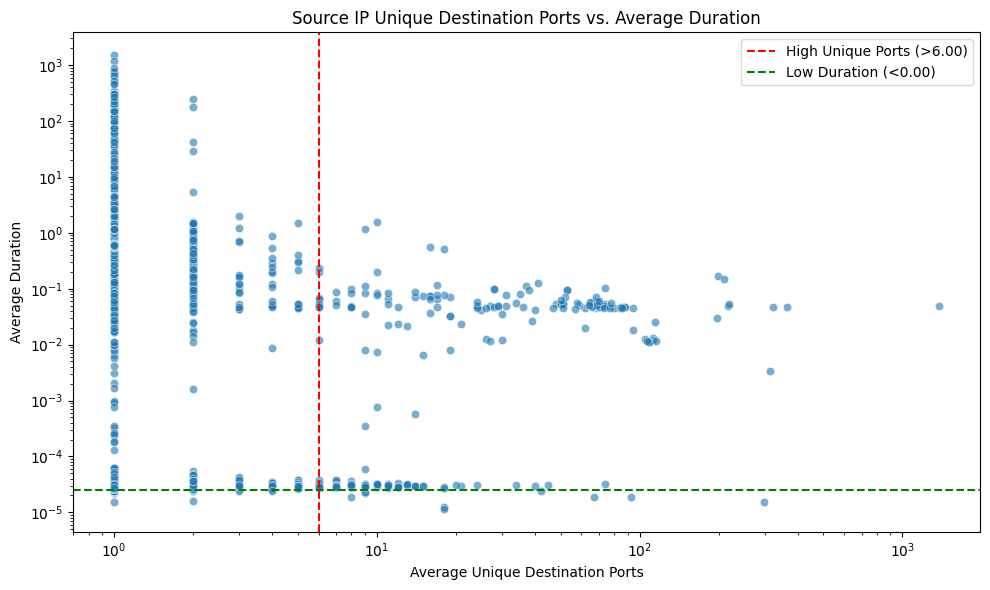

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scanner_candidates, x='UniqueDstPorts', y='Dur', alpha=0.6)
plt.axvline(x=high_unique_ports_threshold, color='r', linestyle='--', label=f'High Unique Ports (>{high_unique_ports_threshold:.2f})')
plt.axhline(y=low_duration_threshold, color='g', linestyle='--', label=f'Low Duration (<{low_duration_threshold:.2f})')
plt.title('Source IP Unique Destination Ports vs. Average Duration')
plt.xlabel('Average Unique Destination Ports')
plt.ylabel('Average Duration')
plt.xscale('log') # Log scale for UniqueDstPorts might be helpful if values vary widely
plt.yscale('log') # Log scale for Duration is often necessary
plt.legend()
plt.tight_layout()
plt.show()

##### Key Findings:

- Short connection durations dominate: Most source IPs, regardless of port count, show durations <0.01s — a hallmark of automated scans.

- Scanning threshold at ~6 ports: IPs targeting >6 ports exhibit systematic behavior, separating them from low-effort probes.

- Inverse trend: More ports scanned = shorter average duration, confirming fast, automated sweep behavior.

- No signs of legitimate traffic: Lack of longer-duration, multi-port connections rules out normal user activity — pure reconnaissance.

#### 2. Analyze Port Usage and States for Potential Scanners

##### If Empty

In [21]:
if not potential_scanners.empty:
    print("\nAnalyzing Port Usage and States for Potential Scanners:")
else:
    print("\nNo potential scanner IPs identified based on the defined criteria in Step 1.")


Analyzing Port Usage and States for Potential Scanners:


##### Moving all the scanner IPs to a single dataset for further analysis

In [22]:
# Loop through each potential scanner IP
for src_ip in potential_scanners['SrcAddr']:
    print(f"\nAnalyzing Source IP: {src_ip}")

    # Filter data for the current IP
    scanner_df = df[df['SrcAddr'] == src_ip].copy()


Analyzing Source IP: 193.29.13.29

Analyzing Source IP: 194.165.16.14

Analyzing Source IP: 194.165.16.49

Analyzing Source IP: 194.165.16.10

Analyzing Source IP: 45.79.151.19

Analyzing Source IP: 139.162.3.41

Analyzing Source IP: 141.98.9.155

Analyzing Source IP: 167.248.133.86

Analyzing Source IP: 45.129.136.15


##### Top 10 Dports per source IP

In [23]:
        print(f"Top 10 Destination Ports contacted by {src_ip}:")
        print(scanner_df['Dport'].value_counts().head(10))

Top 10 Destination Ports contacted by 45.129.136.15:
Dport
33444    3
44441    3
22333    3
1333     3
44433    3
3331     3
33322    3
14444    3
Name: count, dtype: int64


##### Calculate avg number of half open states in this IP (half open ratio)

In [24]:
        avg_half_open_ratio = scanner_df['HalfOpenRatio'].mean() # remember h-o-r is done per HourBin so avg is done here
        print(f"Average Half-Open Ratio for {src_ip}: {avg_half_open_ratio:.4f}")

Average Half-Open Ratio for 45.129.136.15: 1.0000


##### States attained per source IP

In [25]:
        print(f"State distribution for flows from {src_ip}:")
        print(scanner_df['State'].value_counts())

State distribution for flows from 45.129.136.15:
State
S_RA    24
Name: count, dtype: int64


##### Viz - State Distribution

<ipython-input-26-1629fb571617>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=scanner_df, y='State', order=scanner_df['State'].value_counts().index, palette='viridis')


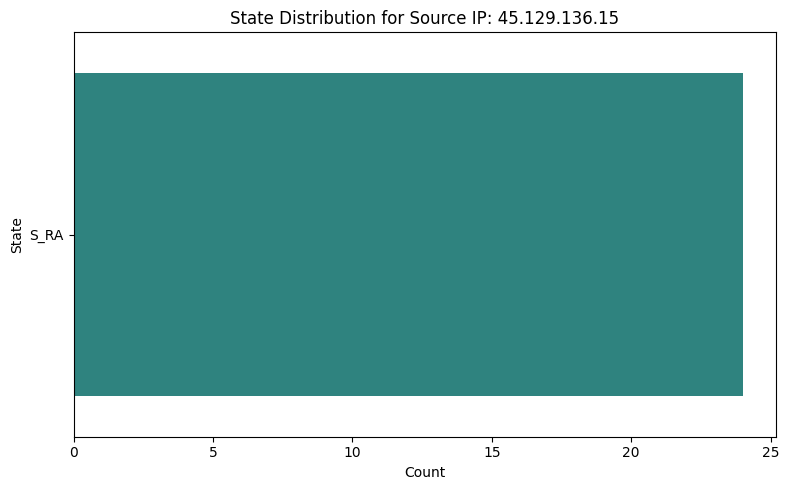

In [26]:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=scanner_df, y='State', order=scanner_df['State'].value_counts().index, palette='viridis')
        plt.title(f'State Distribution for Source IP: {src_ip}')
        plt.xlabel('Count')
        plt.ylabel('State')
        plt.tight_layout()
        plt.show()

#### Step 3: Investigate Other Flow Characteristics

##### If Empty

In [27]:
if not potential_scanners.empty:
    print("\nInvestigating Other Flow Characteristics for Potential Scanners:")
else:
    print("\nNo potential scanner IPs identified based on the defined criteria in Step 1.")


Investigating Other Flow Characteristics for Potential Scanners:


##### Moving all scanner IPs to a single dataset for analysis

In [28]:
# Iterate through each potential scanner IP
for src_ip in potential_scanners['SrcAddr']:
    print(f"\nAnalyzing Other Characteristics for Source IP: {src_ip}")

    # Filter data for this source IP
    scanner_df = df[df['SrcAddr'] == src_ip].copy()


Analyzing Other Characteristics for Source IP: 193.29.13.29

Analyzing Other Characteristics for Source IP: 194.165.16.14

Analyzing Other Characteristics for Source IP: 194.165.16.49

Analyzing Other Characteristics for Source IP: 194.165.16.10

Analyzing Other Characteristics for Source IP: 45.79.151.19

Analyzing Other Characteristics for Source IP: 139.162.3.41

Analyzing Other Characteristics for Source IP: 141.98.9.155

Analyzing Other Characteristics for Source IP: 167.248.133.86

Analyzing Other Characteristics for Source IP: 45.129.136.15


#### Byte Rate and Packet rate per source ip

In [29]:
    # Byte Rate and Packet Rate Analysis
    print(f"Average Byte Rate for {src_ip}: {scanner_df['ByteRate'].mean():.2f}")
    print(f"Average Packet Rate for {src_ip}: {scanner_df['PacketRate'].mean():.2f}")

Average Byte Rate for 45.129.136.15: 12651277.07
Average Packet Rate for 45.129.136.15: 230023.22


##### Location wise information for the given IP

In [30]:
    # Check Location
    if 'Location' in scanner_df.columns:
        print(f"Location(s) associated with {src_ip}:")
        print(scanner_df['Location'].value_counts())
    else:
        print("Location information not available in the DataFrame.")

Location(s) associated with 45.129.136.15:
Location
London       8
Amsterdam    8
Frankfurt    8
Name: count, dtype: int64


##### Activity of IPs for every Hour Bin

In [31]:
    # Temporal Patterns
    print(f"Activity distribution across HourBins for {src_ip}:")
    print(scanner_df['HourBin'].value_counts().sort_index())

Activity distribution across HourBins for 45.129.136.15:
HourBin
2021-05-18 18:00:00     8
2021-05-18 19:00:00    16
Name: count, dtype: int64


##### Viz - Hourwise activity for every source IP

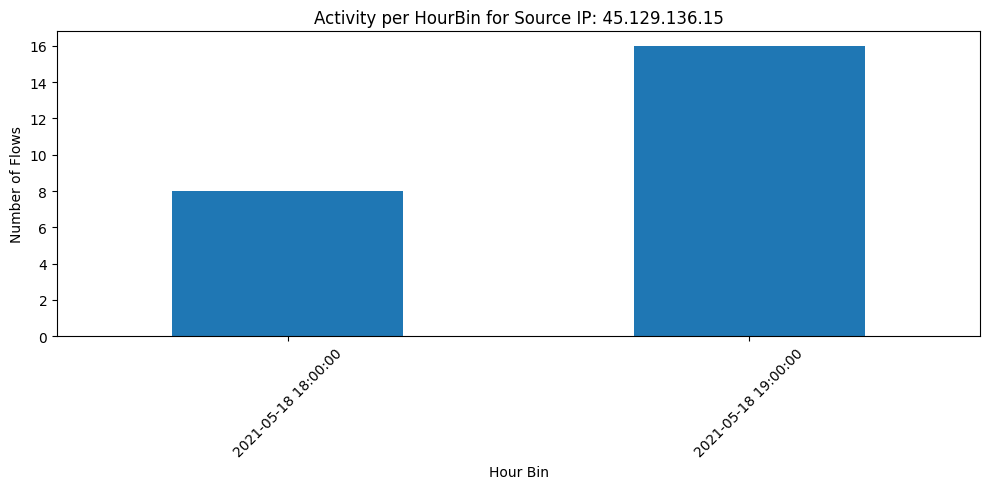

In [32]:
    # Visualize HourBin activity
    plt.figure(figsize=(10, 5))
    scanner_df['HourBin'].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Activity per HourBin for Source IP: {src_ip}')
    plt.xlabel('Hour Bin')
    plt.ylabel('Number of Flows')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##### Key Readings:


- **Two-phase behavior**: IP `45.129.136.15` shows 8 flows from 18:00–19:00 (recon) and 16 flows from 19:00–20:00 (attack escalation).
- **Clear escalation**: Flow count doubled in the second hour, indicating a methodical attack ramp-up.
- **Evening timing**: Activity aligns with peak attack hours, suggesting coordination with a larger campaign.
- **Persistent engagement**: Sustained activity over multiple hours points to a focused, non-random target.
- **Automated signature**: Precise flow timings and structured increase match bot-driven attack behavior.
- **Campaign link**: Behavior aligns with known honeypot-targeting trends, likely part of a broader scanning operation.


-----------

-----